# Shapley for data valuation

This notebook introduces Shapley methods for the computation of data value using pyDVL.

In order to illustrate the practical advantages, we will predict the popularity of songs in the dataset [Top Hits Spotify from 2000-2019](https://www.kaggle.com/datasets/paradisejoy/top-hits-spotify-from-20002019), and highlight how data valuation can help investigate and boost the performance of the models. In doing so, we will describe the basic usage patterns of pyDVL.

Recall that data value is a function of three things:

1. The dataset.
2. The model.
3. The performance metric or scoring function.

Below we will describe how to instantiate each one of these objects and how to use them for data valuation. Please also see the [documentation on data valuation][data-valuation-intro].

## Setup

We begin by importing the main libraries and setting some defaults.

<div class="alert alert-info">

If you are reading this in the documentation, some boilerplate (including most plotting code) has been omitted for convenience.

</div>

In [1]:
%matplotlib inline

import os
import random

import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics._scorer import neg_mean_absolute_error_scorer
from support.datasets import load_spotify_dataset

plt.ioff()  # Prevent jupyter from automatically plotting
plt.rcParams["figure.figsize"] = (20, 6)
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)

is_CI = os.environ.get("CI")
random_state = 24
random.seed(random_state)
n_jobs = 4
if is_CI:
    n_jobs = 1

We will use the following classes and functions from pyDVL. The main entry point is the class
[ShapleyValuation][pydvl.valuation.methods.shapley.ShapleyValuation], which provides the implementation of the Shapley method. In order to use it we need to instantiate two [Datasets][pydvl.valuation.dataset.Dataset], a [PermutationSampler][pydvl.valuation.samplers.PermutationSampler] (with a [RelativeTruncation][pydvl.valuation.samplers.truncation.RelativeTruncation] policy to stop computation early), a [SupervisedScorer][pydvl.valuation.scorers.SupervisedScorer] to evaluate the model on the held-out test set, and a [ModelUtility][pydvl.valuation.utility.ModelUtility] to hold the model and the scoring function.

In [2]:
from pydvl.reporting.plots import plot_result_errors
from pydvl.valuation.dataset import Dataset, GroupedDataset
from pydvl.valuation.methods.shapley import ShapleyValuation
from pydvl.valuation.samplers import PermutationSampler, RelativeTruncation
from pydvl.valuation.scorers import SupervisedScorer
from pydvl.valuation.stopping import HistoryDeviation, MaxUpdates
from pydvl.valuation.utility import ModelUtility

## Loading and grouping the dataset

pyDVL provides a support function for this notebook, `load_spotify_dataset()`, which downloads data on songs published after 2014, and splits 30% of data for testing, and 30% of the remaining data for validation. The return value is a triple of training, validation and test data as lists of the form `[X_input, Y_label]`.

In [3]:
train_data, val_data, test_data = load_spotify_dataset(
    val_size=0.3, test_size=0.2, target_column="popularity", random_state=random_state
)

In [4]:
# In CI we only use a subset of the training set
if is_CI:
    ci_test_artists = ["Billie Eilish", "DJ Snake", "Eminem", "Adele", "Maroon 5"]
    train_data[0] = train_data[0][train_data[0]["artist"].isin(ci_test_artists)]
    train_data[1] = train_data[1][train_data[0].index]

In [5]:
train_data[0].head()

,artist,duration_ms,explicit,year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
1588,Joel Adams,210580,False,2015,0.513,0.768,4,-4.868,0,0.0587,0.0118,0.000019,0.2940,0.235,84.264,1
1674,Jonas Blue,196613,False,2016,0.742,0.819,1,-5.307,1,0.0487,0.3720,0.000000,0.2770,0.709,117.986,15
1957,Stormzy,196266,True,2019,0.682,0.653,8,-6.062,1,0.3390,0.1300,0.001160,0.1290,0.428,188.115,5
1707,Maroon 5,214265,False,2018,0.783,0.610,7,-6.124,1,0.0696,0.3430,0.000000,0.0983,0.418,100.047,14
1536,The Weeknd,235653,True,2015,0.480,0.682,7,-4.940,1,0.1300,0.0696,0.000000,0.0463,0.506,167.939,17


The dataset has many high-level features, some quite intuitive (`duration_ms` or `tempo`), while others are a bit more cryptic (`valence`?).

For detailed information on each feature, please consult [the dataset's website](https://www.kaggle.com/datasets/paradisejoy/top-hits-spotify-from-20002019).

In our analysis, we will use every column except `artist` and `song` to predict the `popularity` of each song.

In [6]:
artists = train_data[0]["artist"]
train_data[0] = train_data[0].drop(["artist"], axis=1)
test_data[0] = test_data[0].drop(["artist"], axis=1)
val_data[0] = val_data[0].drop(["artist"], axis=1)

Input and label data are then used to instantiate [Dataset][pydvl.valuation.dataset.Dataset] objects:

In [7]:
train_dataset = Dataset(
    *train_data, feature_names=train_data[0].columns, target_names=["popularity"]
)
test_dataset = Dataset(
    *test_data, feature_names=train_data[0].columns, target_names=["popularity"]
)
val_dataset = Dataset(
    *val_data, feature_names=train_data[0].columns, target_names=["popularity"]
)

The calculation of exact Shapley values is computationally very expensive (exponentially so!) because it requires training the model on every possible subset of the training set. For this reason, PyDVL implements techniques to speed up the calculation, such as Monte Carlo approximations, [surrogate models][pydvl.valuation.utility.learning.DataUtilityLearning] or [caching][pydvl.utils.caching] of intermediate results and grouping of data to calculate Shapley values of groups of data points instead of single data points.

In our case, we will group songs by artist and calculate the Shapley values for the artists. The class [GroupedDataset][pydvl.valuation.dataset.GroupedDataset] takes an array mapping indices to group identifiers. These identifiers are 0-indexed and must be integers, so we can't use the artist names directly. Instead, we map the artist names to integers and use these as group identifiers. Note that we also cannot use the artist ids which are non-contiguous. We build the necessary mappings below.

In [8]:
artist_to_gid = {
    artist: i for i, artist in enumerate(artists.unique())
}  # 1:1 artist name -> group id
gid_to_artist = [
    artist for artist, i in sorted(artist_to_gid.items(), key=lambda x: x[1])
]  # 1:1 group id -> artist name
song_to_gid = [
    artist_to_gid[x] for x in artists
]  # n:1 song loc[] in the data -> group id

grouped_train_dataset = GroupedDataset.from_dataset(
    train_dataset, data_groups=song_to_gid, group_names=gid_to_artist
)

In [9]:
print(f"Size of the original dataset: {len(train_dataset)}")
print(f"Size of the grouped dataset: {len(grouped_train_dataset)}")

Size of the original dataset: 284
Size of the grouped dataset: 184


The songs are now grouped by artist, and values will be computed per-group. This is a common scenario in data valuation. On the one hand the data points are naturally grouped, and it is more informative to know the value of the group than the value of each data point. On the other, it is computationally much cheaper to calculate the value of a few groups than the value of each data point.

## Creating the utility and computing values

Now we can calculate the contribution of each group to the model performance.

As a model, we use scikit-learn's [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html), but pyDVL can work with any model from sklearn, xgboost or lightgbm. More precisely, any model that implements the protocol [SupervisedModel][pydvl.utils.types.SupervisedModel] (which is just the standard scikit-learn interface of `fit()`,`predict()` and `score()`) can be used to construct the utility.

The third and final component is the scoring function. It can be anything like accuracy or $R^2$, and is set, in the simplest way, by passing a string from the [standard sklearn scoring methods](https://scikit-learn.org/stable/modules/model_evaluation.html) to the `SupervisedScorer` class. Please refer to that documentation on information on how to define your own scoring function.

We collect validation dataset, model and scoring function into an instance of [ModelUtility][pydvl.valuation.utility.modelutility.ModelUtility].

In [10]:
utility = ModelUtility(
    model=GradientBoostingRegressor(n_estimators=3, random_state=random_state),
    scorer=SupervisedScorer(
        "neg_mean_absolute_error", test_data=val_dataset, default=0.0
    ),
    show_warnings=False,
)

Now we configure the valuation method. Shapley values were popularized for data valuation in machine learning with _Truncated Monte Carlo Shapley_, which is a Monte Carlo approximation of the Shapley value that uses a permutation-based definition of Shapley values and truncates the iteration over a given permutation after the marginal utility drops below a certain threshold. For more information on the method, see [Ghorbani and Zou (2019)](https://proceedings.mlr.press/v97/ghorbani19c.html) or [pydvl's documentation][pydvl.valuation.methods.shapley.ShapleyValuation].

Like every semi-value method, `ShapleyValuation` requires a sampler and a stopping criterion. For the former we use a [PermutationSampler][pydvl.valuation.samplers.permutation.PermutationSampler], which samples permutations of indices and computes marginal contributions incrementally. By using [RelativeTruncation][pydvl.valuation.samplers.truncation.RelativeTruncation], the processing of a permutation will stop once the utility of a subset is close to the total utility. Finally, the stopping condition for the whole algorithm is given as in the TMCS paper: we stop once the total change in the last 100 steps is below a threshold.

In [ ]:
from joblib import parallel_config

from pydvl.valuation import MinUpdates

valuation = ShapleyValuation(
    utility=utility,
    sampler=PermutationSampler(
        truncation=RelativeTruncation(rtol=0.01), seed=random_state
    ),
    is_done=MinUpdates(200)
    & (HistoryDeviation(n_steps=100, rtol=0.01) | MaxUpdates(1000)),
    progress=True,
)
with parallel_config(n_jobs=n_jobs):
    valuation.fit(grouped_train_dataset)
result = valuation.result

Let's take a look at the values by converting them to a dataframe:

In [12]:
result.sort().to_dataframe(column="data_value", use_names=True)

,data_value,data_value_variances,data_value_counts
Kungs,-1.331776,5.592036,200
AJR,-1.263026,1.196279,200
A Boogie Wit da Hoodie,-1.049198,2.672556,200
Justin Bieber,-1.021131,0.178952,200
Martin Jensen,-0.883811,8.560035,200
...,...,...,...
Calvin Harris,0.252377,1.199611,200
Zedd,0.261765,1.976527,200
Ella Mai,0.303578,2.485929,200
21 Savage,0.390234,22.699210,200


The first thing to notice is that we sorted the results in ascending order of Shapley value. The index holds the labels for each data group: in this case, artist names. The column `data_value` is just that: the Shapley Data value. `data_value_variance` is the sample variance of the Monte Carlo estimate, and `data_value_count` is the number of updates to the estimate.

Let us plot the results. In the next cell we will take the 30 artists with the lowest score and plot their values with 95% Normal confidence intervals. Keep in mind that Monte Carlo Shapley is typically very noisy, and it can take many steps to arrive at a clean estimate.

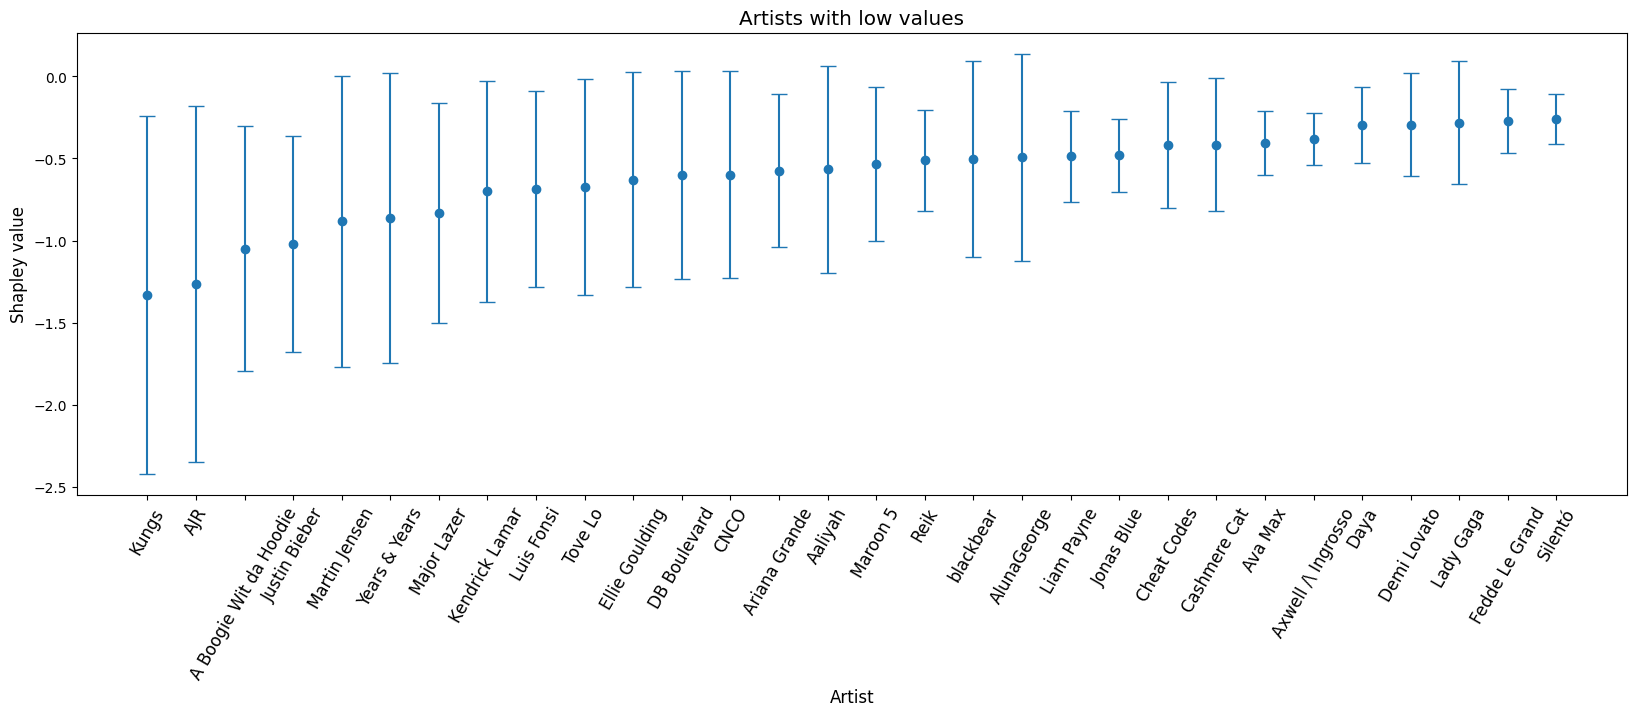

In [13]:
low_dvl = valuation.result.sort()[:30]
plot_result_errors(
    low_dvl,
    level=0.05,
    title="Artists with low values",
    xlabel="Artist",
    ylabel="Shapley value",
)
plt.show()

We can immediately see that many artists (groups of samples) have very low, even negative value, which means that they tend to decrease the total score of the model when present in the training set! What happens if we remove them?

In the next cell we create a new training set excluding the artists within the bottom 10% scores:

In [14]:
lower_bound = np.percentile(result.values, 10)
selected_indices = result.indices[result.values > lower_bound]
clean_dataset = grouped_train_dataset[selected_indices]

In [15]:
print(
    f"Size of the original dataset: {len(grouped_train_dataset)} artists ({len(grouped_train_dataset.data().x)} songs)"
)
print(
    f"Size of the cleaned dataset: {len(clean_dataset)} artists ({len(clean_dataset.data().x)} songs)"
)

Size of the original dataset: 184 artists (284 songs)
Size of the cleaned dataset: 165 artists (253 songs)


Now we will use this **"cleaned"** dataset to retrain the same model and compare its mean absolute error to the one trained on the full dataset. Notice that the score now is calculated using the test set, while in the calculation of the Shapley values we were using the validation set.

In [16]:
model_clean_data = GradientBoostingRegressor(
    n_estimators=3, random_state=random_state
).fit(*clean_dataset.data())
error_good_data = neg_mean_absolute_error_scorer(model_clean_data, *test_dataset.data())

model_all_data = GradientBoostingRegressor(n_estimators=3).fit(*train_dataset.data())
error_all_data = neg_mean_absolute_error_scorer(model_all_data, *test_dataset.data())

In [17]:
print(f"Improvement: {100 * (error_all_data - error_good_data) / error_all_data:02f}%")

Improvement: 8.797089%


The score has improved by a noticeable amount! This is quite an important result, as it shows a consistent process to improve the performance of a model by excluding data points from its training set.

<div class="alert alert-warning">

One must however proceed with caution instead of simply throwing away data. For one, the score on `test_dataset` is an estimate of generalization error on unseen data, and the improvement might not be as large upon deployment. It would be advisable to cross-validate this whole process to obtain more conservative estimates. It is also advisable to manually inspect the artists with low value and to try to understand the reason why the model behaves like it does. Finally, remember that **the value depends on the model!** Artists that are detrimental to the Gradient Boosting Regressor might be informative for a different model. Nevertheless, it is likely that the worst ones share some characteristic making them "bad" for other regressors, a property that justifies attempting to transfer values from one model to another, at least for data inspection purposes.

</div>

## Evaluation on anomalous data

One interesting test to validate the idea that Shapley values help locate bogus data, is to corrupt some of it and to monitor how their value changes. To do this, we will take one of the artists with the highest value and set the popularity of all their songs to 0.

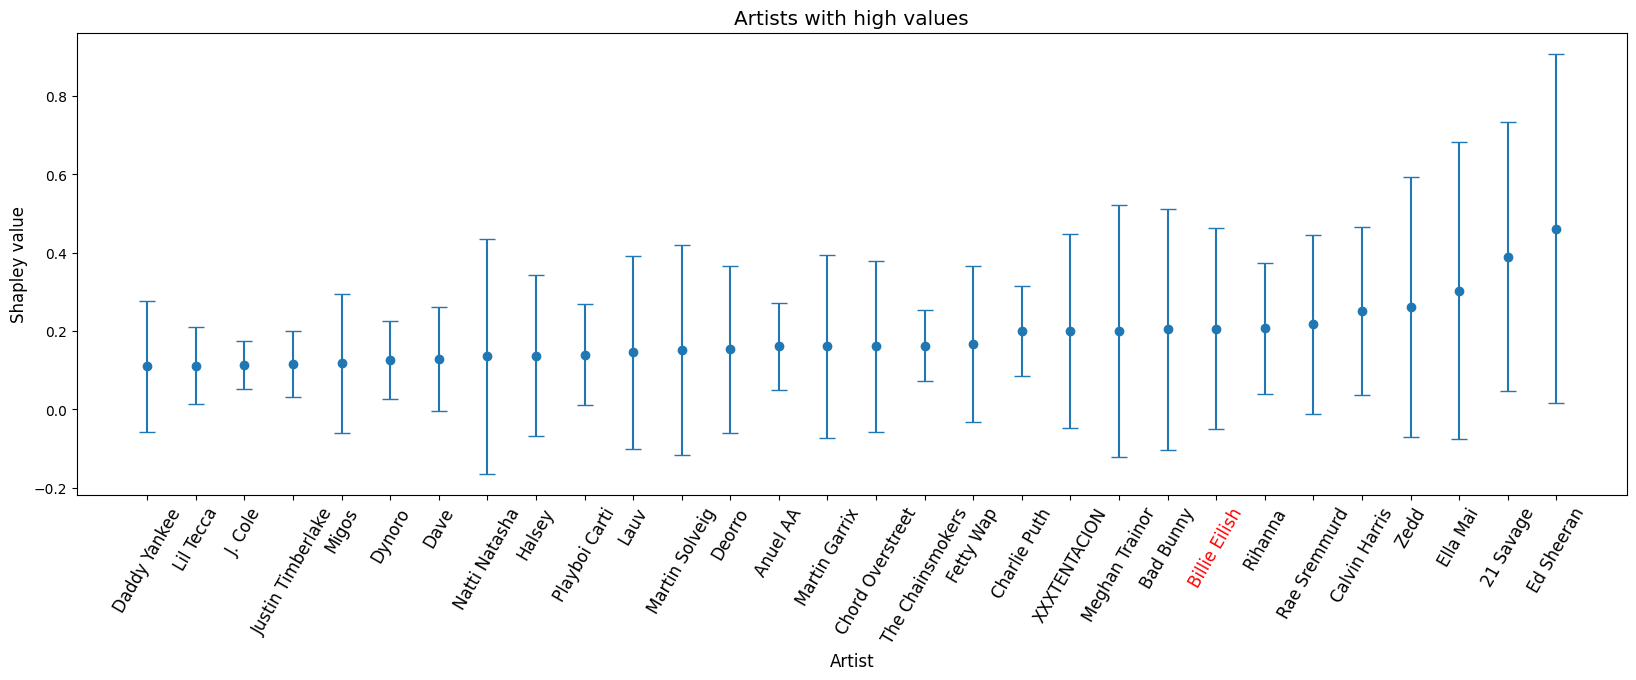

In [29]:
high_dvl = result.sort()[-30:]
ax = plot_result_errors(
    high_dvl,
    title="Artists with high values",
    xlabel="Artist",
    ylabel="Shapley value",
)
BILLIE = artist_to_gid["Billie Eilish"]
ax.get_xticklabels()[high_dvl.positions([BILLIE])[0]].set_color("red")
plt.show()

Let us take all the songs by Billie Eilish, set their score to 0 and re-calculate the Shapley values.

In [30]:
y_train_anomalous = train_data[1].copy(deep=True)
y_train_anomalous[artists == "Billie Eilish"] = 0
anomalous_train_dataset = Dataset(train_data[0], y_train_anomalous)
grouped_anomalous_dataset = GroupedDataset.from_dataset(
    anomalous_train_dataset, data_groups=song_to_gid, group_names=gid_to_artist
)

In [ ]:
anomalous_utility = ModelUtility(
    model=GradientBoostingRegressor(n_estimators=3, random_state=random_state),
    scorer=SupervisedScorer(
        "neg_mean_absolute_error", test_data=val_dataset, default=0.0
    ),
)
valuation = ShapleyValuation(
    utility=anomalous_utility,
    sampler=PermutationSampler(
        truncation=RelativeTruncation(rtol=0.01), seed=random_state
    ),
    is_done=HistoryDeviation(n_steps=100, rtol=1e-3) | MaxUpdates(1000),
    progress=True,
)
with parallel_config(n_jobs=n_jobs):
    valuation.fit(grouped_anomalous_dataset)
result = valuation.result

Let us now consider the low-value artists (at least for predictive purposes, no claims are made about their artistic value!) and plot the results

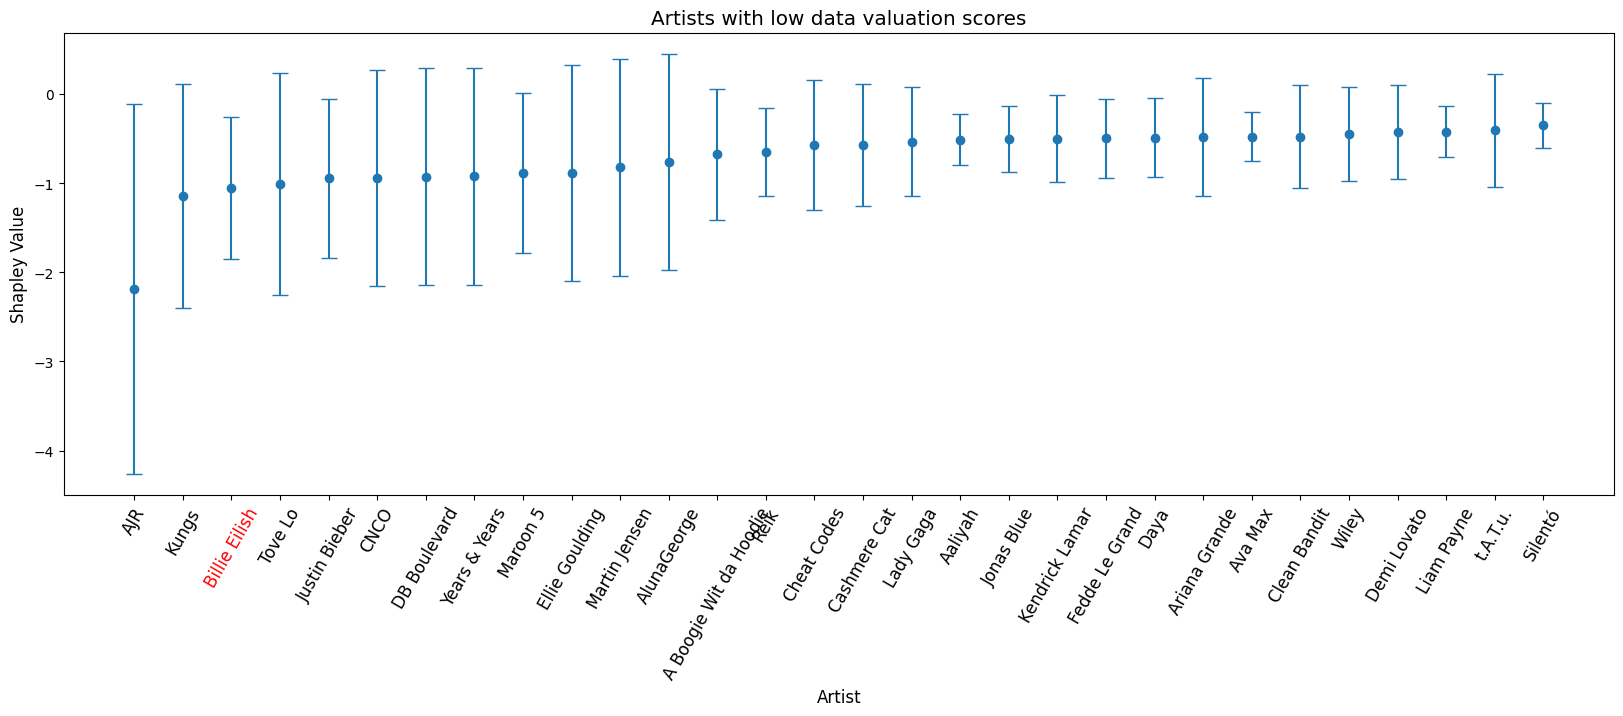

In [32]:
low_dvl = result.sort()[:30]
ax = plot_result_errors(
    low_dvl,
    title="Artists with low data valuation scores",
    xlabel="Artist",
    ylabel="Shapley Value",
)
ax.get_xticklabels()[low_dvl.positions([BILLIE])[0]].set_color("red")
plt.show()

And Billie Eilish (our anomalous data group) has moved from top contributor to having negative impact on the performance of the model, as expected!

What is going on? A popularity of 0 for Billie Eilish's songs is inconsistent with listening patterns for other artists. In artificially setting this, we degrade the predictive power of the model.

By dropping low-value groups or samples, one can often increase model performance, but by *inspecting* them, it is possible to identify bogus data sources or acquisition methods.
